# Financial Indexes as Coupled Oscillators

## Objective:

The goal of this project is to apply my physics experience to finance by modeling interconnected global markets as a network of coupled oscilllators (think pendulums together on a string). By analyzing key metrics such as the resulting coupling matrix $K$, one can uncover underlying coupling strengths between markets, explore the synchronization of markets, and perform stability analysis on the system as a whole. This is not meant to predict prices, but rather probe the dynamics of the system within a given period of time.

## Introduction:

Synchronization in financial markets refers to the extent to which the behaviors of different assets or markets become correlated over time. As synchronization increases, the movements of individual stocks become more dependent on one another, reducing effective diversification. This interdependence can amplify systemic risk: a local shock to one asset or sector may propagate through the network, triggering broader market instability. For instance, if stock A is strongly coupled to stock B, a significant decline in B’s price may lead to a corresponding drop in A’s price, even in the absence of new information. High synchronization across markets may thus signal a fragile equilibrium, where localized disturbances lead to global cascades. In contrast, low synchronization implies greater robustness, as idiosyncratic shocks are more likely to remain contained. To quantify synchronization between financial markets, this project attempts to treat financial markets as a network of coupled oscillators whose phase (movement) is governed by the Kuramoto model.

## Model Overview:

The Kuramoto model is a model for the behavior of a large set of coupled oscillators, shown in equation (1).

$\dot{\theta_i} = \omega_i + \frac{1}{N}\sum_{j=1}^{N}K_{ij}sin(\theta_j - \theta_i)$ (1)

where $\dot{\theta_i}$ is the time derivative of oscillator i's phase, $\omega_i$ is the natural frequency, N is the number of oscillators, and $K_{ij}$ is the coupling matrix that describes how strongly correlated oscillator i and j are. There are assumptions in this model, including that the oscillators are identical or nearly identical and that the interactions depend sinusoidally on the phase difference between each pair of oscillators. As it stands, my Kuramoto model does not include a white noise parameter $\zeta_i(t)$ and is purely deterministic. Future tweaks and inclusions of noise parameters may be desired or necessary for better representation of the stochastic nature of financial markets.

One way of quantifying the cumulative coherence of the system of oscillators is to calculate the "order" parameters $r$ and $\psi$. They are defined as

$re^{i\psi} = \frac{1}{N}\sum_{j=1}^Ne^{i\theta_j}$ (2)

where $r$ represents the phase-coherence and $\psi$ is the average phase of the oscillators. $r$ can have values between 0 (uncoupled) and 1 (full phase-locking).

### Model Procedure:

This model can take N number of financial markets from the Yahoo! finance (yfinance python package). It has been tested on weekly closing prices for up to N = 10 major stock indexes, including ^GSPC, ^IXIC, ^FTSE, and others. Naturally, a high level of synchronization is expected among indexes, as each index aggregates the behavior of numerous underlying stocks. Testing on individual stocks would also be interesting, especially stocks from a diverse set of industries.

Since the current model is purely deterministic, I apply a third-order Savitzky–Golay filter over a 10-week window to smooth the price data for improved fitting. The objective is to analyze global synchronization and large-scale movements rather than local fluctuations, so smoothing should be appropriate as long as it does not obscure these broader trends.

After smoothing, I take the logarithm of the prices, $log(P_i(t))$, and subtract the mean across all assets at each time step, yielding $\theta_i = log(P_i(t)) - \langle log(P_i(t)) \rangle$. This normalization step mitigates differences in absolute price levels between markets or stocks, aiding numerical stability during fitting. Importantly, it does not alter the underlying Kuramoto dynamics, which are invariant under uniform (vertical) shifts across oscillators. The parameters $\omega_i$ and $K_{ij}$ are then extrapolated.

### Concerns/topics that need to be addressed:

1. For N oscillators, there are $N_p$ = N (from $\omega_i$) + N(N-1) (from $K_{ij}$ since the diagonals are zero). So the total number of parameters that need to be fit are $N_p =N^2$. So for N=10, there are 100 parameters that need fitting, which can be computationally heavy and also poses a risk for overfitting if the timespan is not long enough (not enough data). Investigation on preventing overfitting is ongoing.

2. On the topic of overfitting, how reliable are the values of $K_{ij}$? Are they actually meaningful, or did the algorithm just assign values that 'worked'? For example, are negative values meaningful?

3. The symmetry of $K$. Intuitively, it can make sense that one market can have a heavy dependence on another but not the reverse - leading to a descrepancy in $K_{ij}$ vs $K_{ji}$. But should it be somewhat symmetric or symmetric in general? Can a measure of the symmetry tell us anything? This builds off of the previous question (i.e. are the values of $K$ actually meaningful)?

4. How can I better probe synchronization for specific oscillators, not just the system as a whole (done with $r$ parameter)? The values $K_{ij}$ and $K_{ji}$ can point to how coupled they are, but is there another way that can demonstrate coupling. In my 'UnderstandingOscillators' notebook, I did some bifurcation plots, but that was with homogeneous K (not a matrix), can i do something similar if K is a matrix?

### Things to try

1. Unemployment vs job postings or jobs available.
2. Consumer price index and GDP of countries.
3. Test Closing vs Opening prices and weekly vs daily prices.
4. Consumer spending vs unemployment rate.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import yfinance as yf
from scipy.signal import savgol_filter
from scipy.optimize import least_squares
from IPython.display import Math, display
import seaborn as sns
from itertools import combinations

In [ ]:
# Assume K_fit is your (N x N) NumPy array
def latex_matrix(K, name="K"):
    """Return a LaTeX-formatted matrix display"""
    latex_str = f"{name} = \\begin{{bmatrix}}\n"
    for row in K:
        latex_str += " & ".join(f"{v:.3f}" for v in row) + " \\\\\n"
    latex_str += "\\end{bmatrix}"
    return Math(latex_str)

In [ ]:
class KuramotoModel:
    def __init__(self, tickers, start_date, end_date, dt=1.0, sample='Weekly', fwindow=10):
      '''
      Parameters:

      tickers - list of stock/index tickers
      start_date - string specifying day in YYYY-MM-DD format to start taking data
      end_date - string specifying day in YYYY-MM-DD format to end taking data
      dt - time step (default 1.0)
      sample - Determines the sampling of data: "Weekly" for weekly prices, "Monthly" for monthly
               and "Daily" for daily prices (default = "Daily")
      fwindow - Savitzky-Golay filter window size (default 10)

      '''
      self.tickers = tickers
      self.start_date = start_date
      self.end_date = end_date
      self.dt = dt
      self.sample = sample
      self.fwindow = fwindow

    def get_data(self, CorP="Close"):
      '''
      Function that retrieves finance data from yfinance.

      Parameters:
      CorP - "Close" for closing prices, "Open" for opening prices

      Returns:
      P - DataFrame of prices
      '''
      P = yf.download(self.tickers, self.start_date, self.end_date, auto_adjust=False)[CorP].dropna();
      return P

    def preprocess(self, p_df, plot=False):
      '''
      Preprocesses raw price data to generate phase-like variables (theta).

      This method performs the following steps:
      1. Resamples the data (e.g., to weekly or monthly frequency, if specified).
      2. Applies a Savitzky–Golay filter to smooth the time series.
      3. Takes the natural logarithm of the prices.
      4. Subtracts the mean across oscillators at each time step to produce
         θ_i(t) = log(P_i(t)) - ⟨log(P(t))⟩.

      Parameters:
      - p_df: DataFrame of raw prices (unlogged).
      - plot: Whether to visualize raw vs. processed data.

      Returns:
      - theta: 2D array of shape (N, T), representing preprocessed log-price phases.
      '''

      if self.sample == 'Weekly':
          resampled = p_df.resample("W-FRI").last()
      elif self.sample == 'Monthly':
          resampled = p_df.resample("M").last()
      else:
          resampled = p_df.copy()

      resampled = resampled.dropna()
      smoothed = resampled.apply(lambda x: savgol_filter(x, self.fwindow, 3), axis=0)
      smoothed_df = pd.DataFrame(smoothed, index=resampled.index, columns=resampled.columns)

      log_prices = np.log(smoothed_df)
      log_prices.columns = [f"log{col}" for col in log_prices.columns]

      theta = log_prices.values.T
      theta = theta - np.mean(theta, axis=1, keepdims=True)
      dtheta = np.diff(theta, axis=1) / self.dt

      self.theta = theta
      self.dtheta = dtheta
      self.log_prices = log_prices

      if plot:
          fig, ax = plt.subplots(len(self.tickers), 1, figsize=(10, 3 * len(self.tickers)), sharex=True)
          fig.subplots_adjust(hspace=0.5)
          for i, ticker in enumerate(self.tickers):
              ax[i].plot(resampled.index, np.log(resampled[ticker]), label='Raw Log Price', color='green', linestyle='-.')
              ax[i].plot(log_prices.index, log_prices.iloc[:, i], label='Smoothed Log Price', linestyle='--', color='red')
              ax[i].set_title(f"{ticker}")
              ax[i].set_ylabel(r'$\log(P)$')
              ax[i].legend()
          plt.show()

      return theta, dtheta, log_prices

    def initial_guess(self):
      '''
      Computes initial parameter estimates for the Kuramoto model.

      This method estimates the natural frequencies (omega) and the initial coupling matrix (K)
      based on the observed phase dynamics (theta and dtheta). These serve as starting points
      for optimization or fitting procedures.

      Steps:
      1. Estimates omega_i as the time-averaged rate of change in θ_i (i.e., mean of dtheta across time).
      2. Estimates the off-diagonal entries of the coupling matrix K by solving a least-squares
        problem for each oscillator i:
          dtheta_i/dt - omega_i = (1/N) sum_j K_ij * sin(theta_j - theta_i)
        where the sum is taken over j ≠ i.
      3. Flattens and returns only the off-diagonal elements of K for use in parameter vectorization.

      Returns:
      - omega_guess: Array of shape (N,), estimated natural frequencies for each oscillator.
      - K_offdiag: 1D array of length N(N-1), initial guess for off-diagonal elements of the coupling matrix.

      '''
      N, _ = self.theta.shape
      omega_guess = np.mean(self.dtheta, axis=1)
      K_guess = np.zeros((N, N))

      for i in range(N):
          y = self.dtheta[i] - omega_guess[i]
          X = np.stack([
              np.sin(self.theta[j, :-1] - self.theta[i, :-1]) / N
              for j in range(N) if i != j
          ], axis=1)
          coeffs, _, _, _ = np.linalg.lstsq(X, y, rcond=None)

          k = 0
          for j in range(N):
              if i != j:
                  K_guess[i, j] = coeffs[k]
                  k += 1

      K_offdiag = K_guess[~np.eye(N, dtype=bool)]
      return omega_guess, K_offdiag

    def fit(self, omega0, K_offdiag0, lambda_K=0.001, plot=True):
      '''
      Performs the least_squares fit given the intial guesses of the parameters
      from the initial_guess function. It also plots the raw (unsmoothed),
      smoothed, and modeled data together for visual comparison.

      Parameters:
      - omega0: Initial guess for the natural frequencies (omega).
      - K_offdiag0: Initial guess for the off-diagonal elements of the
        coupling matrix (K).

      Returns:
      - omega_fit: Array of shape (N,), estimated natural frequencies for each oscillator.
      - K_fit: Array of shape (N, N), estimated coupling matrix.
      '''
      N, T = self.theta.shape

      def kuramoto(params):
        omega = params[:N]
        K_offdiag = params[N:]
        K_mat = np.zeros((N, N))
        K_mat[~np.eye(N, dtype=bool)] = K_offdiag

        model_theta = np.zeros_like(self.theta)
        model_theta[:, 0] = self.theta[:, 0]

        for t in range(1, T):
            for i in range(N):
                coupling = sum((K_mat[i, j] / N) * np.sin(model_theta[j, t - 1] - model_theta[i, t - 1]) for j in range(N) if i != j)
                dtheta_i = omega[i] + coupling
                model_theta[i, t] = model_theta[i, t - 1] + dtheta_i * self.dt

        model_dtheta = np.diff(model_theta, axis=1) / self.dt
        return model_theta, model_dtheta, K_mat

      def residuals(params):
        model_th, _, K_mat = kuramoto(params)
        core_resid = (model_th - self.theta).flatten()
        asym_penalty = lambda_K * np.sum((K_mat - K_mat.T) ** 2)
        penalty_vector = np.ones_like(core_resid) * (asym_penalty / len(core_resid))
        return core_resid + penalty_vector

      params0 = np.concatenate([omega0, K_offdiag0])
      fit = least_squares(residuals, params0)

      omega_fit = fit.x[:N]
      K_offdiag_fit = fit.x[N:]
      K_fit = np.zeros((N, N))
      K_fit[~np.eye(N, dtype=bool)] = K_offdiag_fit

      best_params = np.concatenate([omega_fit, K_offdiag_fit])
      theta_model, _, _ = kuramoto(best_params)

      if plot:
        raw = self.get_data()
        raw = raw.resample("W-FRI").last().dropna()
        log_raw = np.log(raw)
        log_raw.columns = [f"log{col}" for col in log_raw.columns]
        log_raw = log_raw.reindex(self.log_prices.index).dropna()
        raw_log = log_raw.values.T
        raw_log = raw_log - np.mean(raw_log, axis=1, keepdims=True)

        ncols= 2
        nrows = int(np.ceil(N / ncols))

        fig, axes = plt.subplots(nrows, ncols, figsize=(14, 5 * nrows), sharex=True)
        axes = np.atleast_1d(axes).flatten()

        for i in range(N):
            ax = axes[i]
            ax.plot([], [], color='none', label=f'Mean Square Difference = {np.mean((theta_model[i] - self.theta[i]) ** 2):.2e}')
            ax.plot(self.log_prices.index, self.theta[i], label=f'Smoothed Data of {self.tickers[i]}', color='black')
            ax.plot(self.log_prices.index, theta_model[i], label=fr'Model $\theta_{{{i+1}}}(t)$', linestyle='--', color='red')
            ax.plot(self.log_prices.index, raw_log[i], label=f'Raw Data of {self.tickers[i]}', linestyle='-.', color='green')

            ax.legend()
            ax.grid(True)

            # Remove y-axis labels from the right column
            if i % ncols == 0:
                ax.set_ylabel(r'$\log(P_i(t)) - \langle \log(P_i(t)) \rangle$')

            if i // ncols == nrows - 1:
              ax.set_xlabel("Date")

        # Remove unused axes (if any)
        for j in range(N, len(axes)):
            fig.delaxes(axes[j])

        plt.suptitle("Actual vs Modeled Phase Dynamics", fontsize=14)
        plt.tight_layout()  # Reduce space between columns
        plt.show()

      Kdis = display(latex_matrix(K =K_fit, name="K^{fit}"))
      omega_latex = r"\omega^{fit} = \begin{bmatrix}" + r" \\".join([f"{w:.2e}" for w in omega_fit]) + r"\end{bmatrix}"
      display(Math(omega_latex))
      sns.heatmap(K_fit, annot=True, cmap='viridis')

      return omega_fit, K_fit


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed


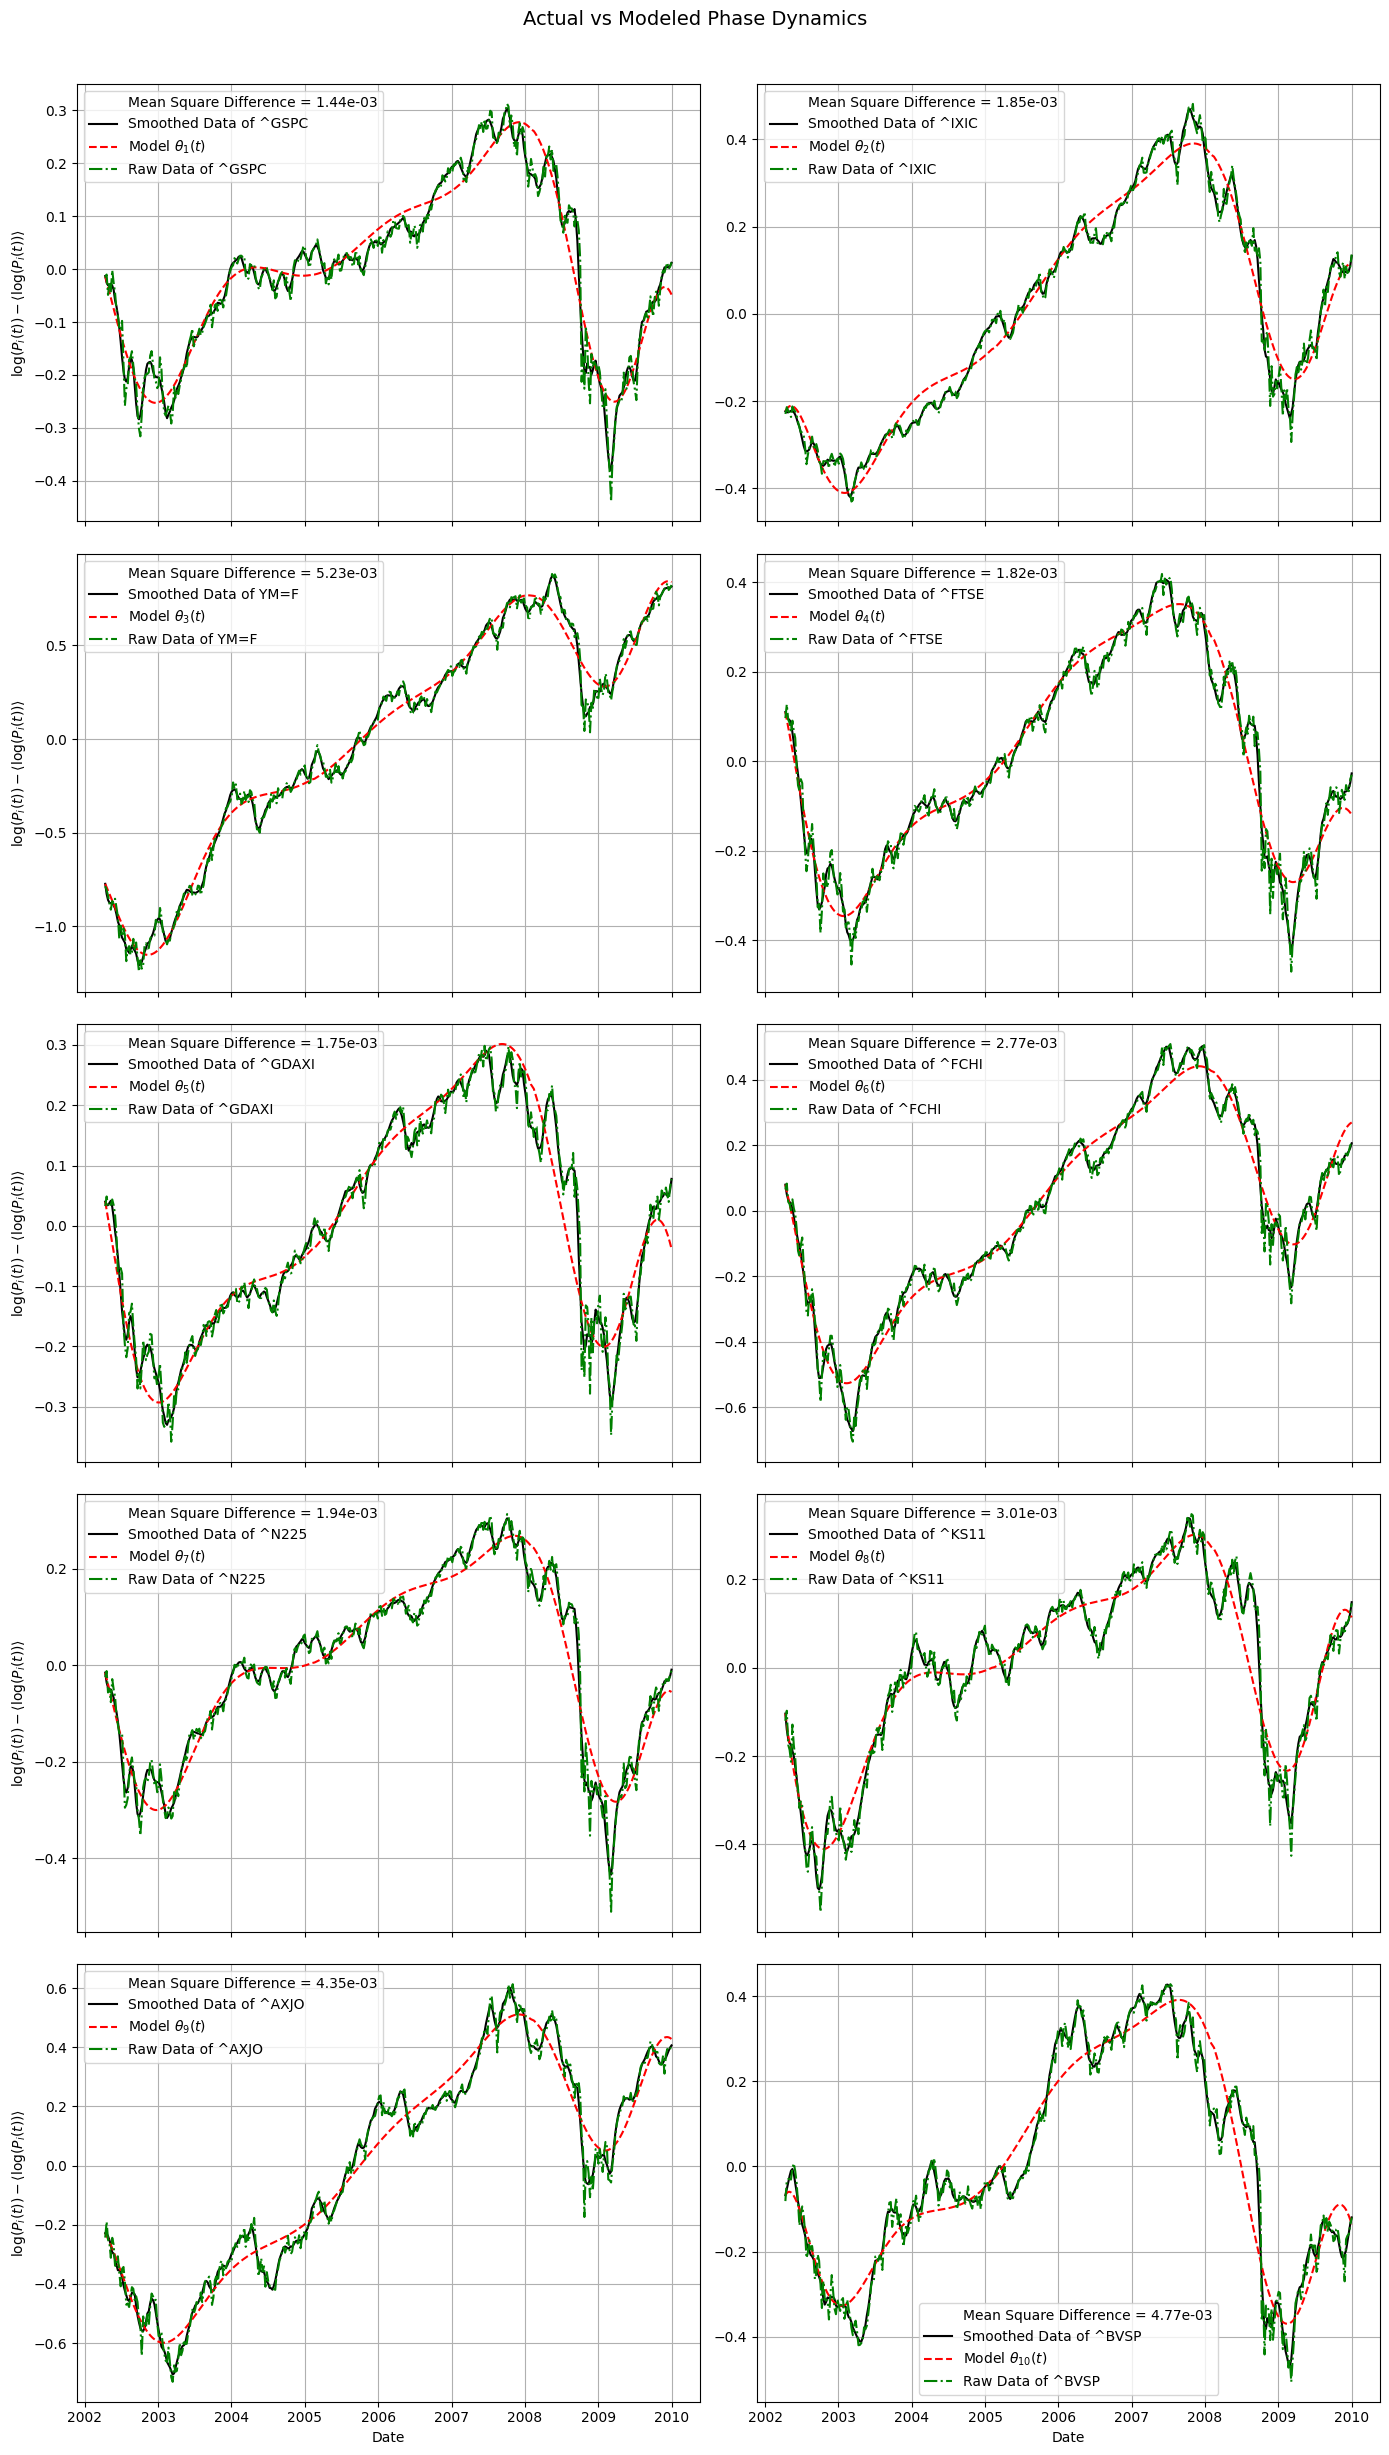

<IPython.core.display.Math object>

<IPython.core.display.Math object>

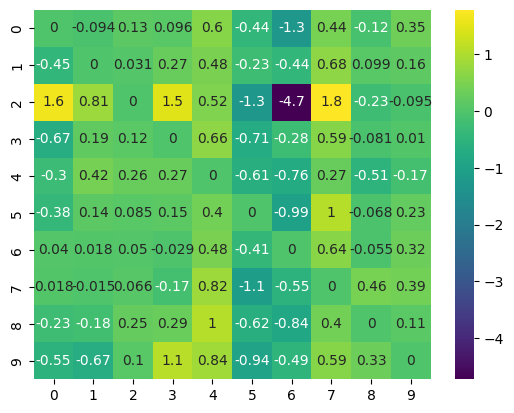

In [ ]:
tickers = ["^GSPC","^IXIC", "YM=F","^FTSE","^GDAXI","^FCHI", "^N225", "^KS11","^AXJO","^BVSP"]
start_date = "2000-01-01"
end_date = "2010-01-01"

# Uses weekly closing dates, smooths data w/window of 10 weeks
model = KuramotoModel(tickers, start_date, end_date, dt=1.0, sample="Weekly", fwindow=10)
price_data = model.get_data()
theta, dtheta, log_prices = model.preprocess(price_data, plot=False)
omega0, K0 = model.initial_guess()
omega_fit, K_fit = model.fit(omega0, K0, lambda_K=0.001, plot=True)


## Computing the order parameter $r$ to visualize systemic synchronization.

[*********************100%***********************]  10 of 10 completed


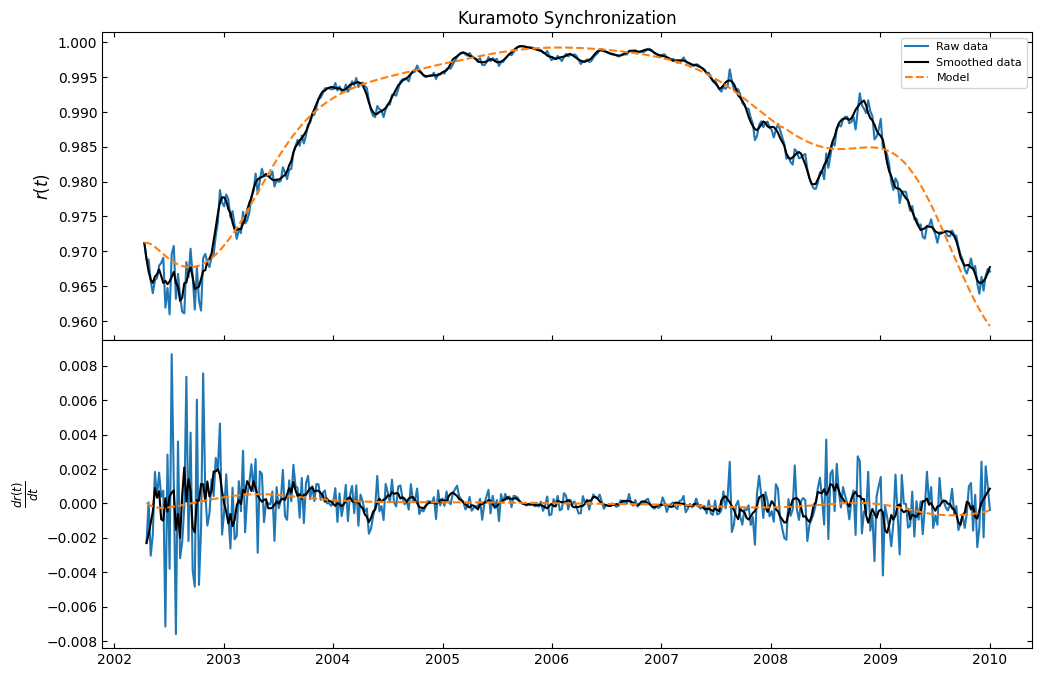

In [ ]:
def compute_order_parameter(theta,dt):
    """
    Compute the Kuramoto order parameter r(t) from phase data.

    Parameters:
    - theta: ndarray of shape (N, t), phases of N oscillators over time

    Returns:
    - r: ndarray of shape (t,), coherence value r(t) at each timestep
    """
    z = np.exp(1j * theta.T)        # transpose to shape (t, N)
    r_complex = np.mean(z, axis=1)  # average over oscillators
    r = np.abs(r_complex)           # magnitude gives coherence
    drdt = np.diff(r) / dt
    return r, drdt

dt = model.dt
N, T = theta.shape

def Kuramoto(params):
  omega = params[:N]
  K_offdiag = params[N:]

  K_mat = np.zeros((N,N))
  K_mat[~np.eye(N, dtype = bool)] = K_offdiag

  model_theta = np.zeros_like(theta)
  model_theta[:, 0] = theta[:, 0]

  for t in range(1, T):
      for i in range(N):
          coupling = sum((K_mat[i, j]/N) * np.sin(model_theta[j, t - 1] - model_theta[i, t - 1]) for j in range(N) if i!= j)
          dtheta_i = omega[i] + coupling
          model_theta[i, t] = model_theta[i, t - 1] + dtheta_i * dt

  # Compute model dtheta from simulated theta
  model_dtheta = np.diff(model_theta, axis=1) / dt  # shape (N, T-1)
  return model_theta, model_dtheta, K_mat

theta_m, dtheta_m, _ = Kuramoto(np.concatenate([omega_fit, K_fit[~np.eye(10, dtype = bool)].flatten()]))

raw = model.get_data()
raw = raw.resample("W-FRI").last().dropna()
log_raw = np.log(raw)
log_raw.columns = [f"log{col}" for col in log_raw.columns]
log_raw = log_raw.reindex(raw.index).dropna()
raw_log = log_raw.values.T
raw_log = raw_log - np.mean(raw_log, axis=1, keepdims=True)


r, dr = compute_order_parameter(theta,dt)  # theta: shape (N, t)
r_raw, dr_raw = compute_order_parameter(raw_log,dt)
r_model, dr_model = compute_order_parameter(theta_m,dt)

fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Top subplot: r(t)
axs[0].plot(log_prices.index, r_raw, label='Raw data')
axs[0].plot(log_prices.index, r, color='black', label='Smoothed data')
axs[0].plot(log_prices.index, r_model, linestyle='--', label='Model')
axs[0].tick_params(direction = 'in', which = 'both', top =True, right = True)
# axs[0].axvline(x=pd.to_datetime("2007-08-09"), color='blue', linestyle='--', label='BNP Paribas freezes funds (credit markets freeze)')
# axs[0].axvline(x=pd.to_datetime("2007-02-01"), color='grey', linestyle='--', label='Initial default wave (HSBC)')
# axs[0].axvline(x=pd.to_datetime("2008-01-18"), color='purple', linestyle='--', label='Stocks fall after Ambac rating decreased')
# axs[0].axvline(x=pd.to_datetime("2006-08-1"), color='red', linestyle='--', label = 'The yield curve inverted, signaling a recession was likely within a year or two.')
# axs[0].axvline(x=pd.to_datetime("2008-11-6"), color='green', linestyle='--')
axs[0].set_ylabel('$r(t)$', fontsize = 12)
axs[0].legend(loc = 'best',fontsize = 8)
axs[0].set_title('Kuramoto Synchronization')

# Bottom subplot: dr/dt
axs[1].plot(log_prices.index[1:], dr_raw, label='Raw data')
axs[1].plot(log_prices.index[1:], dr, color='black', label='Smoothed data')
axs[1].plot(log_prices.index[1:], dr_model, linestyle='--', label='Model')
axs[1].tick_params(direction = 'in', which = 'both', top =False, right = True)
# axs[1].axvline(x=pd.to_datetime("2007-08-09"), color='blue', linestyle='--', label='BNP Paribas freezes funds (credit markets freeze)')
# axs[1].axvline(x=pd.to_datetime("2007-02-01"), color='grey', linestyle='--', label='Initial default wave (HSBC)')
# axs[1].axvline(x=pd.to_datetime("2008-01-18"), color='purple', linestyle='--', label='Stocks fall after Ambac rating decreased')
# axs[1].axvline(x=pd.to_datetime("2006-08-1"), color='red', linestyle='--', label = 'The yield curve inverted, signaling a recession was likely within a year or two.')
# axs[1].set_xlabel('Time (t)')
axs[1].set_ylabel(r'$\frac{dr(t)}{dt}$', fontsize = 12)

plt.subplots_adjust(hspace = 0.0)
# plt.tight_layout()
plt.show()



## Calculating the phase differences of each. Ideally, if there is a convergence, then we can say the thetas are phase-locked. If there is no convergence, then they are not strongly coupled. If the curves like sinusoidal with fixed amplitude, it could be indicative of quasi-periodicity.

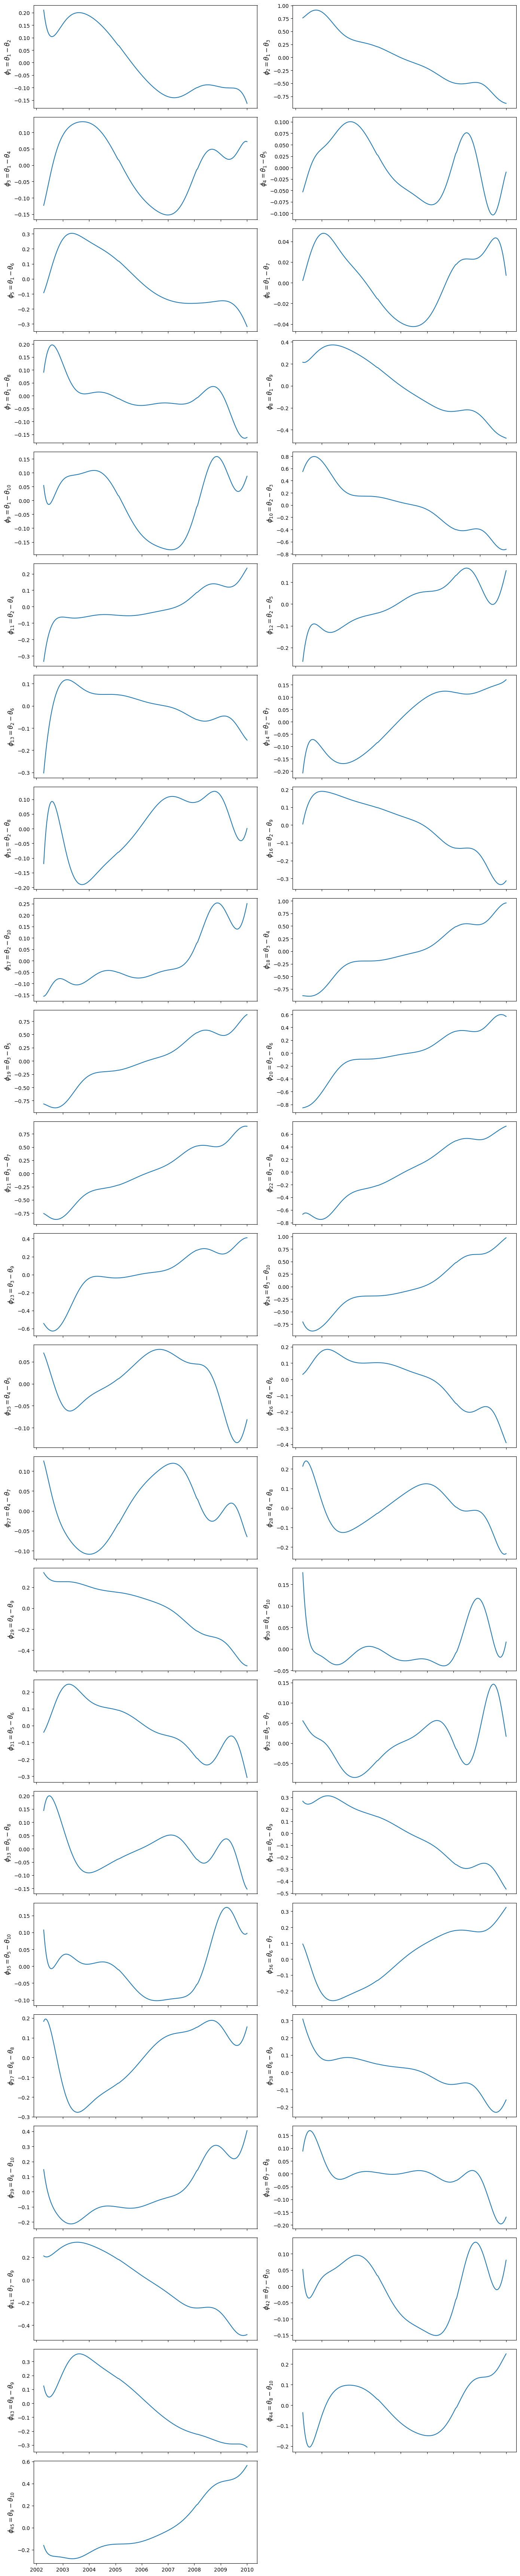

In [ ]:
pairs = list(combinations(range(N), 2))
phi = np.zeros((len(pairs), theta.shape[1]))

for idx, (i, j) in enumerate(pairs):
    phi[idx] = theta_m[i] - theta_m[j]

# Set up grid
fontsize = 12
n_plots = len(pairs)

if N % 2 == 0:
    ncols = 2
else:
    ncols = 3  # or 2 — you decide how many columns you want for odd N
nrows = int(np.ceil(n_plots / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(14, 3 * nrows), sharex=True)
axes = np.atleast_1d(axes).flatten()  # Flatten in case it's a 2D array

for i in range(n_plots):
    ax = axes[i]
    ax.plot(log_prices.index, phi[i])
    ax.set_ylabel(rf'$\phi_{{{i+1}}} = \theta_{{{pairs[i][0]+1}}} - \theta_{{{pairs[i][1]+1}}}$', fontsize=fontsize)

# Hide any unused subplots
for i in range(n_plots, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
threshold = 0.05  # radians or whatever unit theta is in
locked_pairs = []
print('Phi showing phase-locking' + ':' + '(Thetai,Thetaj)')
for idx, pair in enumerate(pairs):
    std_phi = np.std(phi[idx])
    if std_phi < threshold:
        locked_pairs.append((pair, std_phi))
        display(Math(fr'\phi_{{{idx+1}}} = {locked_pairs[-1][0][0]+1, locked_pairs[-1][0][1]+1}'))

Phi showing phase-locking:(Thetai,Thetaj)


<IPython.core.display.Math object>

<IPython.core.display.Math object>